# Singapore Flat Resale Prices 1990-Present

- Month - Month of sale
- Type - Designated residential area with its own amenities, infrastructure, and community facilities
- Flat Type - Classification of units by room size. They range from 2 to 5 rooms, 3Gen units, and Executive units.
- Block - A HDB building comprising multiple flats or apartments
- Street Name - Name of the road the HDB flat is located along
- Storey Range - Estimated range of floors the unit sold was located on
- Floor Area - Total interior space within the unit, measured in square meters
- Flat Model - Classification of units by generation of which the flat was made, ranging from New Generation, DBSS, Improved, Apartment
- Lease Commence Date - Starting point of a lease agreement, marking the beginning of the lease term during which the tenant has the right to use and occupy the leased property
- Resale Price - Cost of the flat sold

In [1]:
from src.config import PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR, FIGURES_DIR
import pandas as pd
import geopandas as gpd
import numpy as np

2025-07-24 19:52:33.398 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /Users/Edward/Documents/GitHub/sg-flat-resale


In [2]:
# Import geojson file
town_geo = gpd.read_file(EXTERNAL_DATA_DIR / 'district_and_planning_area.geojson')

# Import and load cleaned data
filename = PROCESSED_DATA_DIR / 'ResaleFlatPrices-Processed.csv'
df = pd.read_csv(PROCESSED_DATA_DIR / filename)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,year,month,region,town,flat_type,flat_model,storey_count,start_floor,floor_area_sqm,lease_year,years_leased,resale_price,infl_adj_price
0,1990-01-01,1990,1,North-East,Ang Mo Kio,1 Room,Improved,2,10,31.0,1977,13,9000.0,17252.5
1,1990-01-01,1990,1,North-East,Ang Mo Kio,1 Room,Improved,2,4,31.0,1977,13,6000.0,11501.7
2,1990-01-01,1990,1,North-East,Ang Mo Kio,1 Room,Improved,2,10,31.0,1977,13,8000.0,15335.6
3,1990-01-01,1990,1,North-East,Ang Mo Kio,1 Room,Improved,2,7,31.0,1977,13,6000.0,11501.7
4,1990-01-01,1990,1,North-East,Ang Mo Kio,3 Room,New Generation,2,4,73.0,1976,14,47200.0,90480.0


## Exploratory Data Analysis

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Questions
- By how much have resale prices increased over the years?
- By how much do resale prices differ across towns, flat types, and flat models?
- Does the number of years leased significantly affect resale prices? If so, by how much? Does the lease commence date have more of an impact than the number of years leased?
- How much resale price volatility exists across towns, flat types, and flat models?
- Do the storey ranges significantly affect resale prices? Presumably, higher floors could cost more; or less, depending on the flat type. It could be that it's undesirable for multigenerational flats to be on higher floors since elderly people would also be residents
- What geospatial data analysis can be done here? Surely, the house prices must be correlated geographically.
- Does the pricing of the flat types over time follow Weber's law?

In [16]:
# Create a custom colourmap
colours = ["#ff4500", "#faa272", "#ffdab9", "#0088ff", "#003376"]
cmap = mcolors.LinearSegmentedColormap.from_list("", colours)

from src.utils.plotting import multi_stop_gradient
from src.utils.plotting import catplots
from src.utils.misc import bin_numbers

In [ ]:
# Create copy of main dataframe for plotting purposes
df_p = df.copy()
df_p['year_binned'] = df_p['year'].apply(lambda a: bin_numbers(a, 1990, 10))
df_p['lease_year_binned'] = df_p['lease_year'].apply(lambda a: bin_numbers(a, 1960, 10))
df_p['years_leased_binned'] = df_p['years_leased'].apply(lambda a: bin_numbers(a, 0, 10))
df_p['start_floor_binned'] = df_p['start_floor'].apply(lambda a: bin_numbers(a, 1, 10))
df_p['quarter'] = df_p['month'].apply(lambda a: bin_numbers(a, 1, 3))
df_p['quarter'] = df_p['quarter'].replace({'1-3': 'Q1', '4-6': 'Q2', '7-9': 'Q3', '10-12': 'Q4',})

x_vars = ['year', 'lease_year', 'years_leased', 'month']

In [ ]:
cr = df[['year', 'floor_area_sqm', 'storey_count', 'start_floor',
         'lease_year', 'years_leased', 'resale_price', 'infl_adj_price']].corr(method='pearson')

fig = go.Figure(go.Heatmap(
    x=cr.columns,
    y=cr.columns,
    z=cr.values.tolist(),
    colorscale='RdBu', zmin=-1, zmax=1
))

# Set plot size and add title
fig.update_layout(
    autosize=False,
    title=dict(text='Correlations Between Numerical Variables', x=0.03),
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=50, b=20),
)

fig.show()

### Units Resold
Explorations of the number of units resold

In [17]:
catplots(df_p, x_vars, 'flat_type', 'Units Resold By Flat Type', 'count')

It appears that peak selling times were between 1998 and 2002. What market conditions could have been responsible for the many sales? And what caused the spike in 2010?

Property hold times suggest people cannot flip HDB properties before the 5 year mark. This is confirmed from the HDB website where the HDB stipulates a 5-year minimum occupancy period (MOP) for Unclassified/ Standard flats or flats bought from private property developers under the Design, Build and Sell Scheme (DBSS), and 10-year MOP for Plus and Prime flats.  
Number of units sold tapers off after the 15 year mark. This could either be due to people not wanting to sell homes they have lived for a long time in or due to a housing development boom about 7 to 15 years ago, meaning that the number of units from this period is far greater than earlier periods (i.e. there simply weren't that many HDB apartments 50 years ago).  
If there was a boom in new HDB developments, what could have precipitated it? Perhaps indicatively, an article from Singapore's National Library Board shows that the DBSS was launched in 2005 but was initally met with a slow uptake by property developers who expressed concerns about the unpredictability of the market, the numerous HDB regulations, and the apartment surplus the HDB always seemed to have. While the pilot development was launched in 2006 and opened in 2009, most of the subsequent developments were launched between 2008 and 2011, and opened between 2011 and 2015, adding a total of 8,533 new units. The unpopularity and eventual scrapping of the program suggests that the DBSS is not responsible for the spike.

In [18]:
catplots(df_p, x_vars, 'years_leased_binned', 'Units Resold By Years Leased', 'count')

In [19]:
catplots(df_p, x_vars, 'lease_year_binned', 'Units Resold By Lease Year', 'count')

In [21]:
catplots(df_p, x_vars, 'flat_model', 'Units Resold By Flat Model', 'count')

In [22]:
catplots(df_p, x_vars, 'quarter', 'Units Resold By Quarter', 'count')

In [71]:
num_vars = ['month', 'date', 'years_leased', 'storey_count', 'start_floor', 'floor_area_sqm']

# Plot units resold per num_var
fig = go.Figure()
buttons = []

for i, num_var in enumerate(num_vars):
    df_g = df.groupby([num_var]).size().reset_index(name='count')

    # If the num_var is datetime, sort set tick format
    if pd.api.types.is_datetime64_any_dtype(df[num_var]):
        df_g.sort_values(by=num_var, inplace=True)
        tick_format = "%Y"
    else:
        tick_format = None

    fig.add_trace(go.Scatter(
        x=df_g[num_var],
        y=df_g['count'],
        mode='lines',
        name=num_var,
        visible=(i==0),
        line=dict(color='gray'),
        ))

    # Dropdown button per trace
    button = dict(
        label=num_var.replace('_', ' ').title(),
        method='update',
        args=[{'visible': [j == i for j in range(len(num_vars))]},
              {'xaxis': {'tickformat': tick_format}}]
    )
    buttons.append(button)

# Add dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.01,
            y=1,
            xanchor='left',
            yanchor='top',
            direction='down',
            type='buttons'
        )
    ],
    autosize=False,
    width=1100,
    height=500,
    margin=dict(l=20, r=20, t=50, b=20),
    title='Units Resold by Feature'
)

fig.show()

In [80]:
variables = ['region', 'flat_type', 'year_binned',]
df_plot = df_p.groupby(variables, group_keys=False).size().reset_index(name='count')
fig = px.sunburst(df_plot, path=variables, values='count')

# Set plot size and add title
fig.update_layout(
    autosize=False,
    title=dict(text='Number of Units Sold by Flat Type and Quarter', x=0.03),
    width=600,
    height=400,
    margin=dict(l=20, r=20, t=50, b=20),
)

fig.show()

## Resale Price
Exploration of the average resale prices, both with and without inflation adjustment. 

In [24]:
catplots(df_p, x_vars, 'flat_type', 'Median Flat Resale Price By Flat Type (Inflation Adjusted)', 'median')

It looks like the mean price of the cheapest apartments has been steadily increasing over the years? What is driving this price increase? Could it be due to cultural changes in the country? It might be useful to plot the mean price by flat type and another variable such as starting floor to investigate what could be driving this shift. It could also be that there are fewer 1 bedroom and 2 bedroom homes available for **sale** (not rent) which could be driving the price trends.

In any case, it might also help to calculate the difference between the most expensive homes (Multi Generation) and the cheapest homes (1 Bedroom) to visualise how the delta has shrunk over time.

In [25]:
catplots(df_p, x_vars, 'start_floor_binned', 'Median Resale Price By Starting Floor (Inflation Adjusted)', 'median')

In [26]:
catplots(df_p, x_vars, 'region', 'Median Resale Price By Region (Inflation Adjusted)', 'median')

In [21]:
median_exec = df[df['flat_type']=='Executive'].groupby(by=['year'])['infl_adj_price'].median().reset_index(name='median_price_executive')
median_1room = df[df['flat_type']=='1 Room'].groupby(by=['year'])['infl_adj_price'].median().reset_index(name='median_price_1room')
price_gap = median_exec.merge(median_1room, on='year')
price_gap['price_ratio'] = price_gap['median_price_executive'] / price_gap['median_price_1room']

# Create the line plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=price_gap['year'],
    y=price_gap['price_ratio'],
    mode='lines+markers',
    line=dict(color='firebrick', width=3),
    marker=dict(size=8),
    name='Executive / 1 Room',
))

fig.update_layout(
    title=dict(
        text='<b>Price Ratio Over Time</b><br><sup>From 1990 to 2024, the gap in price between the cheapest and most expensive apartments has shrunk dramatically</sup>',
        x=0.1,
        xanchor='left',
        y=0.95,
        yanchor='top'
    ),
    xaxis_title='Year',
    yaxis_title='Price Ratio',
    yaxis=dict(tickformat=".2f"),
    template='plotly_white',
    width=900,
    height=500,
    margin=dict(l=50, r=50, t=100, b=50)
)

fig.show()

/var/folders/s0/f5rjt2b943x41srzy579gf8c0000gn/T/ipykernel_51353/880036053.py:9: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



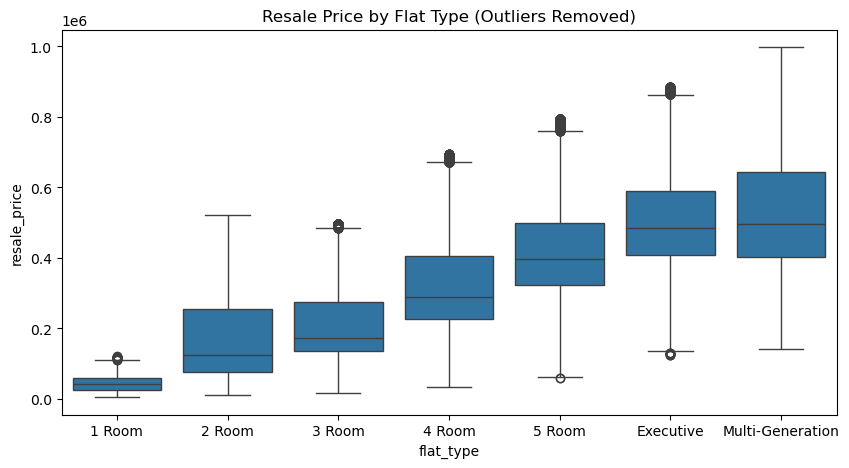

In [22]:
# Define a function to remove outliers for each flat_type category
def remove_outliers(df, group_col, value_col):
    def iqr_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        return group[(group[value_col] >= Q1 - 1.5 * IQR) & (group[value_col] <= Q3 + 1.5 * IQR)]
    
    return df.groupby(group_col, group_keys=False).apply(iqr_filter)

# Apply the function to dataset
df_filtered = remove_outliers(df, 'flat_type', 'resale_price')

# Plot cleaned data
df_plot = df_filtered.sort_values('flat_type')
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='flat_type', y='resale_price')
plt.title('Resale Price by Flat Type (Outliers Removed)')
plt.show()

## Lease Year and Number of Years Leased
Exploring the distribution of the number of years an apartment was leased for and the year it was leased.

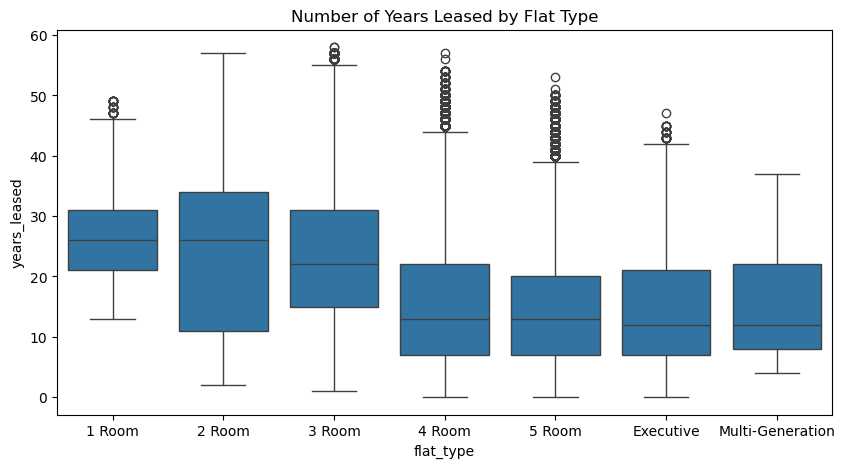

In [23]:
df_plot = df.sort_values('flat_type')

plt.figure(figsize = (10,5))
sns.boxplot(data=df_plot, x='flat_type', y='years_leased')
plt.title('Number of Years Leased by Flat Type')
plt.show()

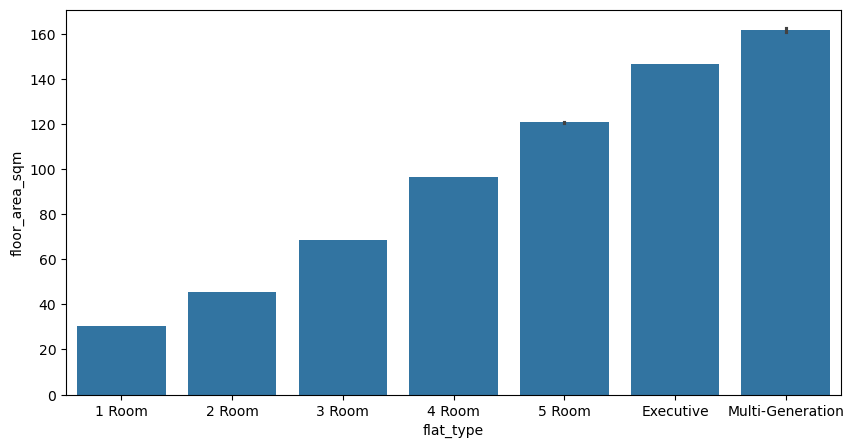

In [24]:
df_plot = df.sort_values('flat_type')
plt.figure(figsize = (10,5))
sns.barplot(data=df_plot, x='flat_type', y='floor_area_sqm')
plt.show()

In [25]:
fig = px.treemap(df, path=['flat_type', 'flat_model'], values='infl_adj_price')

# Set plot size and add title
fig.update_layout(
    autosize=False,
    title=dict(text='Treemap Chart of Comparing Inflation Adjusted Resale Prices by Flat Type and Flat Model', x=0.03),
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=50, b=20),
)

fig.show()